In [1]:
import numpy as np
import networkx as nx
from scipy import stats
import pandas as pd
from pywhy_graphs.viz import draw
from networkx import ancestors
from causalnex.structure import StructureModel

In [2]:
import pandas as pd
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
from causalnex.network import BayesianNetwork as CNBayesianNetwork
import pgmpy.inference.CausalInference as CI
from causalnex.discretiser import Discretiser
from causalnex.inference import InferenceEngine

/Users/vv/project-OperatorsOfTheNeuron/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Parameters

In [3]:
n0 = 85
n_bins = 5
graph_file = "adj.csv"

In [4]:
def cn_from_df(df, sm, m, n_bins, mode='cn'):
    ancestor_data = df[m]
    m_nodes = ["n" + str(i) for i in m]
    df = ancestor_data #.iloc[:100, :]
    df.columns = m_nodes
    bin_means = np.zeros((len(df.columns), n_bins))
    for i, col in enumerate(df.columns):
        # df.loc[:, col] = p
        u, bins = pd.cut(df[col], bins=n_bins, labels=False, retbins=True)
        # for i in range(len(bins) - 1):
            # df.loc[u == i, col] = bins[i] + (bins[i + 1] - bins[i]) / 2
        df.loc[:, col] = u
        for b in range(len(bins) - 1):
            bin_means[i, b] = bins[b] + (bins[b + 1] - bins[b]) / 2
    if mode == 'cn':
        cn = CNBayesianNetwork(sm)
        cn = cn.fit_node_states_and_cpds(df)
        ie = InferenceEngine(cn)
        return cn, ie, bin_means
    else:
        bn = BayesianNetwork(sm)
        bn.fit(df)
        return bn

In [5]:
A = np.loadtxt(graph_file, delimiter=",")

# graph creation
df_low = pd.read_csv(f"dataset/low_scrap.csv")
df_high = pd.read_csv(f"dataset/high_scrap.csv")
df = pd.concat([df_low, df_high], axis=0)


stations = df.keys()
stations = [station[7:] for station in stations]

def process_df(df):
    df.columns = [str(i) for i in range(len(stations))]

process_df(df)
G = nx.DiGraph()
G.add_nodes_from(range(len(stations)))
for i in range(len(stations)):
    for j in range(len(stations)):
        if A[i, j] == 1:
            G.add_edge(i, j)

m = list(G.predecessors(n0)) + [n0]
m = [str(i) for i in m]

dag = DAG()
dag.add_node(str(n0))
for a in m:
    for b in m:
        if G.has_edge(int(a), int(b)):
            dag.add_edge(str(a), str(b))

draw(dag)

sm_manual = StructureModel()
for e in dag.edges:
    sm_manual.add_edges_from(
        [
            ("n" + e[0], "n" + e[1])
        ]
    )

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/low_scrap.csv'

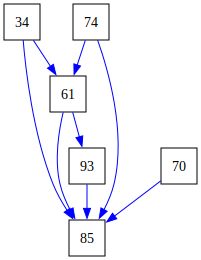

In [48]:
draw(dag)

In [49]:
process_df(df_low)
process_df(df_high)

cn_low, ie_low, bm_low = cn_from_df(df_low, sm_manual, m, n_bins)
cn_high, ie_high, bm_high = cn_from_df(df_high, sm_manual, m, n_bins)

m_strings = ['n' + str(i) for i in m]

/var/folders/wr/gb48q8ld1zs6d76c1nzvz68w0000gn/T/ipykernel_89383/2313523576.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = u
/var/folders/wr/gb48q8ld1zs6d76c1nzvz68w0000gn/T/ipykernel_89383/2313523576.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = u
/var/folders/wr/gb48q8ld1zs6d76c1nzvz68w0000gn/T/ipykernel_89383/2313523576.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [50]:
def marginals(id):
    return ie_low.query()[id], ie_high.query()[id]

In [51]:
for m in m_strings:
    print(m)
    print(marginals(m))

n34
({0: 0.06120000000000033, 1: 0.32960000000000034, 2: 0.42439999999999944, 3: 0.12639999999999982, 4: 0.05840000000000017}, {0: 0.038000000000000034, 1: 0.36840000000000034, 2: 0.45400000000000057, 3: 0.08719999999999993, 4: 0.05240000000000007})
n61
({0: 0.03548535211040337, 1: 0.3525734820454874, 2: 0.2228114929071739, 3: 0.30100710094500427, 4: 0.08812257199192974}, {0: 0.09198561821876232, 1: 0.4087698130640975, 2: 0.08708957192872406, 3: 0.3227272215807336, 4: 0.0894277752076826})
n70
({0: 0.02279999999999992, 1: 0.274399999999999, 2: 0.3047999999999994, 3: 0.31639999999999907, 4: 0.08159999999999976}, {0: 0.02879999999999996, 1: 0.25920000000000004, 2: 0.29200000000000004, 3: 0.34200000000000036, 4: 0.07800000000000008})
n74
({0: 0.04759999999999992, 1: 0.3628000000000007, 2: 0.19080000000000039, 3: 0.2979999999999997, 4: 0.10079999999999993}, {0: 0.0696000000000002, 1: 0.4043999999999987, 2: 0.10959999999999998, 3: 0.31159999999999927, 4: 0.10479999999999945})
n93
({0: 0.0211

In [18]:
ie.do_intervention("n28", 0)
ie.do_intervention("n13", 0)
q = ie.query()
for key in q.keys():
    print(key)
    for k, v in q[key].items():
        print(bin_means[m.index(key[1:]), k], v)

NameError: name 'ie' is not defined